# Kaggle 腰椎変性疾患分類
* タイトル
    * [RSNA 2024 Lumbar Spine Degenerative Classification](https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification)
* 内容
    * このコンテストの目標は、腰椎 MR 画像を使用して変性脊椎疾患の検出と分類を支援するために使用できるモデルを作成することです。参加者は、脊椎疾患の診断における放射線科医の作業をシミュレートするモデルを開発します。
* 期間
    * 2024.05.16-2024.10.01
* 評価方法
    * サンプル加重ログ損失の平均
        * 予測の評価に使用される主要なメトリックは、サンプルごとに加重されたログ損失の平均。
        * 各サンプルには異なる重みが与えられる
            * 正常/軽度 (normal/mild): 重みは 1
            * 中程度 (moderate): 重みは 2
            * 重度 (severe): 重みは 4
    * any_severe_spinal メトリック
        * any_severe_scalar が 1.0 に設定(これは、重度の状態が最も重要視されていることを示す)

---

# ライブラリ

In [5]:
# pip install pydicom

In [6]:
import pandas as pd
import numpy as np

#画像表示
from PIL import Image

#DICOMファイルの読み込みと表示用
import shutil #zipファイルの解凍
import pydicom # ※拡張子.dcmは医療用画像形式ファイルであるため、pythonで読み込むにはpydicomをインポートする必要がある。
import matplotlib.pyplot as plt

---

# データの確認

【このチャレンジでは、左神経孔狭窄、右神経孔狭窄、左関節下狭窄、右関節下狭窄、脊柱管狭窄という 5 つの腰椎変性疾患の分類に焦点を当てます。データセット内の各画像検査では、椎間板レベル L1/L2、L2/L3、L3/L4、L4/L5、L5/S1 の 5 つの疾患それぞれについて、重症度スコア (正常/軽度、中等度、重度) を提供しています。】

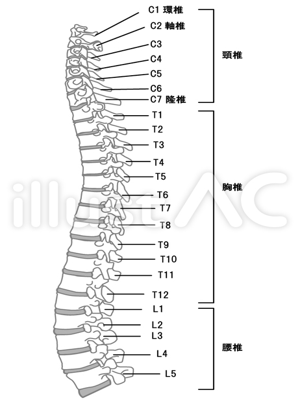

In [7]:
img1 = Image.open('images\sekitui.jpeg')
new_size = (300, 400) 
resized_img = img1.resize(new_size)

resized_img

腰椎はL1～L5の5つの椎骨で形成される。<br>
その椎骨の間（椎間孔）から腰神経が左右に5対伸びている。<br>
この神経が椎間板や椎骨に圧迫されることで腰痛を引き起こす。<br>
腰神経の通路が狭くなり神経を圧迫、つまり狭窄する状態を作り疼痛や痺れなどの症状がでることを総称して腰椎変形性疾患と呼ぶ。

## train.csvの確認

In [8]:
df_train = pd.read_csv('train.csv')
df_train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


* study_id- 研究 ID
    * 各研究には複数の画像シリーズが含まれる場合があります。
* [condition]_[level]等
    * spinal_canal_stenosis_l1_l2重大度レベルはNormal/Mild、  Moderate、またはSevere。一部のエントリのラベルは不完全です。

In [25]:
label_columns = df_train.columns[1:]
# ラベルの分布を計算
label_distribution = df_train[label_columns].melt().groupby(['variable', 'value']).size().reset_index(name='count').sort_values('variable')
#データフレーム化
label_distribution.to_csv('df_label_distribution.csv', index=False)

In [27]:
# 全ての行を表示するための設定
pd.set_option('display.max_rows', None)
# CSVファイルの読み込み
df_label_distribution = pd.read_csv('df_label_distribution.csv')
# データフレームを表示
df_label_distribution

,variable,value,count
0,left_neural_foraminal_narrowing_l1_l2,Moderate,63
1,left_neural_foraminal_narrowing_l1_l2,Normal/Mild,1908
2,left_neural_foraminal_narrowing_l1_l2,Severe,2
3,left_neural_foraminal_narrowing_l2_l3,Moderate,171
4,left_neural_foraminal_narrowing_l2_l3,Normal/Mild,1791
5,left_neural_foraminal_narrowing_l2_l3,Severe,11
6,left_neural_foraminal_narrowing_l3_l4,Moderate,411
7,left_neural_foraminal_narrowing_l3_l4,Normal/Mild,1522
8,left_neural_foraminal_narrowing_l3_l4,Severe,40
9,left_neural_foraminal_narrowing_l4_l5,Severe,140


## train_label_coordinates.csvの確認

In [28]:
df_train_label_coordinates = pd.read_csv('train_label_coordinates.csv')
df_train_label_coordinates.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


* series_id
    * 画像シリーズ ID。
* instance_number
    * 3D スタック内の画像の順序番号。
* condition
    * 中核となる病状は、脊柱管狭窄症、神経孔狭窄症、関節下狭窄症の 3 つです。
    * 最後の 2 つは、脊椎の両側で考慮されます。
* level
    * 関連する椎骨、例えばl3_l4
* [x/y]
    * ラベルを定義する領域の中心の x/y 座標。

In [ ]:
'''zip_file = 'train_images.zip'# 展開したいzipファイルのパス
extract_to = 'train_images'# 展開先のディレクトリ
shutil.unpack_archive(zip_file, extract_to)# Zipファイルを展開する

print(f'{zip_file} を {extract_to} に展開しました。')'''

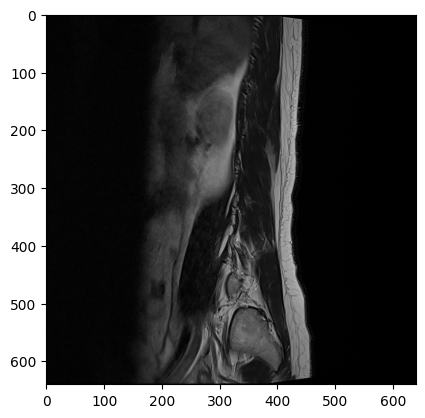

In [15]:
#train_imagesの確認

# DICOMファイルを読み込む
file_path_1 = 'train_images/4003253/702807833/1.dcm'
ds = pydicom.dcmread(file_path_1)

# 画像データを取得
image_10728036_142859125_1 = ds.pixel_array

# 画像を表示
plt.imshow(image_10728036_142859125_1, cmap='gray')
plt.show()

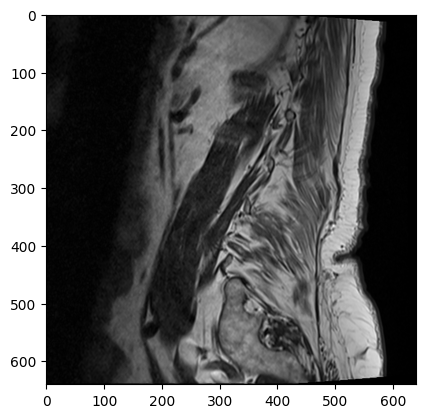

In [16]:
#test_imagesの確認

file_path_2 = 'test_images/44036939/2828203845/1.dcm'
ds = pydicom.dcmread(file_path_2)

image_2828203845_1 = ds.pixel_array

plt.imshow(image_2828203845_1, cmap='gray')
plt.show()

* memo
    * train_images.zip(28.2GB)のダウンロードに3時間かかった。(7/7)